In [1]:
import pandas as pd
import numpy as np
import re
import os
import joblib
import time
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# ML Libraries



In [4]:
!pip install scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, f1_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.calibration import CalibratedClassifierCV

# Deep Learning


In [6]:
!pip install tensorflow
!pip install keras
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import (Dense, LSTM, Embedding, Dropout, Input, 
                                     Bidirectional, BatchNormalization, GlobalMaxPooling1D)
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import Constant

  Using cached tensorflow-2.19.0-cp39-cp39-macosx_12_0_arm64.whl.metadata (4.0 kB)
  Using cached absl_py-2.3.1-py3-none-any.whl.metadata (3.3 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)
  Using cached flatbuffers-25.2.10-py2.py3-none-any.whl.metadata (875 bytes)
  Using cached gast-0.6.0-py3-none-any.whl.metadata (1.3 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl.metadata (814 bytes)
  Using cached libclang-18.1.1-1-py2.py3-none-macosx_11_0_arm64.whl.metadata (5.2 kB)
  Using cached opt_einsum-3.4.0-py3-none-any.whl.metadata (6.3 kB)
  Using cached protobuf-5.29.5-cp38-abi3-macosx_10_9_universal2.whl.metadata (592 bytes)
  Using cached termcolor-3.1.0-py3-none-any.whl.metadata (6.4 kB)
  Using cached wrapt-1.17.2-cp39-cp39-macosx_11_0_arm64.whl.metadata (6.4 kB)
  Using cached tensorboard-2.19.0-py3-none-any.whl.metadata (1.8 kB)
  Using cached keras-3.10.0-py3-none-any.whl.metadata (6.0 kB)
  Using cached h5py-3.14.0-cp39-cp39-macosx_11_0_arm64

# Text preprocessing

In [7]:
np.random.seed(42)
tf.random.set_seed(42)

# Enhanced text preprocessing
def preprocess_bangla_text(text):
    if pd.isna(text):
        return ""
    text = str(text)
    
    # Remove URLs, mentions, hashtags
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    text = re.sub(r'@\w+|#\w+', '', text)
    
    # Remove email addresses and English characters
    text = re.sub(r'\S+@\S+', '', text)
    text = re.sub(r'[a-zA-Z]', '', text)
    
    # Keep Bangla characters and key punctuation
    text = re.sub(r'[^\u0980-\u09FF\s!?.,;:()\[\]{}-]', '', text)
    
    # Remove repeated punctuation and spaces
    text = re.sub(r'([!?.])\1+', r'\1', text)
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text


# Load FastText embeddings

In [8]:
def load_fasttext_embeddings(file_path):
    print(f"Loading FastText embeddings from {file_path}...")
    embeddings_index = {}
    
    # Get file size
    file_size = os.path.getsize(file_path)
    processed = 0
    
    with open(file_path, 'r', encoding='utf-8', errors='ignore') as f:
        # Skip first line (header)
        header = f.readline()
        vocab_size, dim = map(int, header.split())
        
        for line in f:
            values = line.split()
            word = values[0]
            try:
                coefs = np.asarray(values[1:], dtype='float32')
                embeddings_index[word] = coefs
            except:
                continue
                
            # Progress update
            processed += len(line)
            if processed % (100 * 1024 * 1024) == 0:  # Print every 100MB
                print(f"Processed {processed/(1024*1024):.2f} MB/{file_size/(1024*1024):.2f} MB")
    
    print(f"Loaded {len(embeddings_index)} word vectors")
    return embeddings_index, dim


# Build BiLSTM model with FastText embeddings

In [9]:
def build_bilstm_model(embedding_matrix, max_sequence_length, vocab_size, embedding_dim):
    input_layer = Input(shape=(max_sequence_length,))
    
    embedding_layer = Embedding(
        vocab_size,
        embedding_dim,
        embeddings_initializer=Constant(embedding_matrix),
        input_length=max_sequence_length,
        trainable=False
    )(input_layer)
    
    # BiLSTM layers
    bilstm = Bidirectional(LSTM(128, return_sequences=True))(embedding_layer)
    pooled = GlobalMaxPooling1D()(bilstm)
    
    # Dense layers
    dense1 = Dense(128, activation='relu')(pooled)
    dropout1 = Dropout(0.4)(dense1)
    bn1 = BatchNormalization()(dropout1)
    
    dense2 = Dense(64, activation='relu')(bn1)
    dropout2 = Dropout(0.3)(dense2)
    
    output = Dense(3, activation='softmax')(dropout2)
    
    model = Model(inputs=input_layer, outputs=output)
    
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

In [10]:
# Load dataset
print("Loading dataset...")
df = pd.read_csv('comments.csv')
print(f"Original dataset shape: {df.shape}")

Loading dataset...
Original dataset shape: (15015, 8)


In [11]:
df['Sentiment'].value_counts()

Sentiment
Positive    9856
Negative    3722
Neutral     1437
Name: count, dtype: int64

In [12]:
df.sample(10)


,Video Id,Author,Comment,Published At,Likes,Sentiment,Likes (Video),Dislikes (Video)
6407,vDmY5y34uPS,Author_3699,শেষ seen টা নামাজ নিয়ে কথা টা আমার খুব ভালো লা...,2023-06-13 21:18:14,0,Positive,3889,0
3532,u9r1O_jrxoU,Author_824,"Best natok ,,,পরিচালক কে অন্তরের অন্তর স্থল থে...",2023-10-18 18:03:37,2,Positive,1389,0
8054,3Y5rOJKXCjq,Author_5346,"অনেক সুন্দর একটা নাটক,,,,,সার্ভিস হোল্ডালের পর...",2025-03-23 15:39:18,1,Positive,8372,0
14406,WAMNM08cG9t,Author_11698,অসাধারন।,2023-12-23 12:19:41,0,Positive,2724,0
379,Q8GtqiXY0Tc,@AlexAzzurri,mac book e windows install kora jabe ?? taho...,2024-02-08T13:38:58Z,0,Positive,7108,0
5598,G_W1o-VmrJx,Author_2890,আমার দেখা সেরা একটা নাটক।চোখে পানি চলে আসার মতো।,2023-09-02 4:37:47,0,Positive,9154,0
3958,khrYkUcHWJO,Author_1250,"প্রথমে ধন্যবাদ পরিচালক কে,যে এতো সুন্দর একটা ন...",2024-06-09 17:04:05,3,Positive,1709,0
12214,CY0Fe247XVR,Author_9506,"খুব খুব সুন্দর একটি নাটক""Thanks a lot...for ma...",2024-08-15 19:56:20,0,Positive,588,0
1795,E6DimSMlmRU,@Sohidul778,fz 4 থেকে হেডলাইট টেল লাইট বড় এই বাইকের। এটা ভ...,2024-10-02T13:42:35Z,0,Positive,6477,0
13624,Q-9mS_N3b3T,Author_10916,এই নাটকে যারা ডিসলাইক দেয় তারা নিশ্চিত হিরো আল...,2025-02-08 22:20:26,0,Positive,8021,0


In [13]:
# Preprocessing pipeline
df = df[['Comment', 'Sentiment']].copy()
df = df.dropna(subset=['Comment', 'Sentiment'])
df['processed_text'] = df['Comment'].apply(preprocess_bangla_text)
df = df[df['processed_text'].str.len() > 3]  

# Encode labels
label_map = {'Positive': 2, 'Negative': 0, 'Neutral': 1}
df['label'] = df['Sentiment'].map(label_map)
df = df.dropna(subset=['label'])

# Split data with stratification
X = df['processed_text'].values
y = df['label'].values.astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [14]:
df.sample(5)

,Comment,Sentiment,processed_text,label
12348,সেরা ছিলো,Positive,সেরা ছিলো,2
11082,ওসাদারন নাটক টা,Positive,ওসাদারন নাটক টা,2
9839,এন্ডিং ভালো লাগেনি।।,Negative,এন্ডিং ভালো লাগেনি,0
8337,অস্থির এক নাটক এটা,Negative,অস্থির এক নাটক এটা,0
12747,ফালতু নাটক,Negative,ফালতু নাটক,0


# Load FastText embeddings

In [15]:
embeddings_index, EMBEDDING_DIM = load_fasttext_embeddings('cc.bn.300.vec')
MAX_SEQUENCE_LENGTH = 128
VOCAB_SIZE = 50000

Loading FastText embeddings from cc.bn.300.vec...
Loaded 1468578 word vectors


# SVM Model (TF-IDF)



In [16]:
print("Training SVM Model......")

# TF-IDF Vectorization
tfidf = TfidfVectorizer(
    max_features=15000,
    ngram_range=(1, 3),
    min_df=2,
    max_df=0.85,
    sublinear_tf=True,
    norm='l2'
)

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# Calculate class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

# Train SVM with calibration
svm = SVC(
    C=1.5,
    gamma='scale',
    kernel='rbf',
    class_weight=class_weight_dict,
    probability=True,
    random_state=42
)

# Calibrate for better probabilities
calibrated_svm = CalibratedClassifierCV(svm, cv=5, method='sigmoid')
calibrated_svm.fit(X_train_tfidf, y_train)

# Evaluate SVM
svm_pred = calibrated_svm.predict(X_test_tfidf)
svm_acc = accuracy_score(y_test, svm_pred)
svm_f1 = f1_score(y_test, svm_pred, average='weighted')

print(f"\nSVM Test Accuracy: {svm_acc:.4f}")
print(f"SVM Test F1-Score: {svm_f1:.4f}")

Training SVM Model......

SVM Test Accuracy: 0.8105
SVM Test F1-Score: 0.8141


# BiLSTM Model (FastText)

In [17]:
print("Training BiLSTM Model with FastText.....")
# Tokenization
print("\nTokenizing text...")
tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token="<unk>")
tokenizer.fit_on_texts(X_train)

# Prepare embedding matrix
print("Preparing embedding matrix...")
word_index = tokenizer.word_index
num_words = min(VOCAB_SIZE, len(word_index)) + 1

embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
found = 0

for word, i in word_index.items():
    if i >= VOCAB_SIZE:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
        found += 1

print(f"Embedding coverage: {found}/{num_words} ({found/num_words*100:.2f}%)")

# Sequence conversion and padding
print("\nConverting text to sequences...")
train_sequences = tokenizer.texts_to_sequences(X_train)
test_sequences = tokenizer.texts_to_sequences(X_test)

X_train_padded = pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')
X_test_padded = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')

# Build model
print("\nBuilding BiLSTM model...")
bilstm_model = build_bilstm_model(embedding_matrix, MAX_SEQUENCE_LENGTH, num_words, EMBEDDING_DIM)
bilstm_model.summary()

# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6),
    ModelCheckpoint('best_bilstm_model.h5', save_best_only=True, monitor='val_accuracy')
]

# Train model
print("\nTraining BiLSTM model...")
history = bilstm_model.fit(
    X_train_padded, y_train,
    epochs=30,
    batch_size=128,
    validation_split=0.1,
    callbacks=callbacks,
    class_weight=class_weight_dict,
    verbose=1
)

# Load best model
bilstm_model = load_model('best_bilstm_model.h5')

# Evaluate
bilstm_pred = np.argmax(bilstm_model.predict(X_test_padded), axis=1)
bilstm_acc = accuracy_score(y_test, bilstm_pred)
bilstm_f1 = f1_score(y_test, bilstm_pred, average='weighted')

print(f"\nBiLSTM Test Accuracy: {bilstm_acc:.4f}")
print(f"BiLSTM Test F1-Score: {bilstm_f1:.4f}")

Training BiLSTM Model with FastText.....

Tokenizing text...
Preparing embedding matrix...
Embedding coverage: 11597/15252 (76.04%)

Converting text to sequences...

Building BiLSTM model...


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 128, 300)       │     4,575,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 128, 256)       │       439,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 256)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,056,755 (19.29 MB)

 Trainable params: 480,899 (1.83 MB)

 Non-trainable params: 4,575,856 (17.46 MB)


Training BiLSTM model...
Epoch 1/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step - accuracy: 0.5350 - loss: 0.9212

76/76 ━━━━━━━━━━━━━━━━━━━━ 30s 379ms/step - accuracy: 0.5363 - loss: 0.9188 - val_accuracy: 0.7449 - val_loss: 0.7358 - learning_rate: 0.0010
Epoch 2/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step - accuracy: 0.8078 - loss: 0.4489

76/76 ━━━━━━━━━━━━━━━━━━━━ 29s 379ms/step - accuracy: 0.8080 - loss: 0.4487 - val_accuracy: 0.7748 - val_loss: 0.5745 - learning_rate: 0.0010
Epoch 3/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step - accuracy: 0.8500 - loss: 0.3711

76/76 ━━━━━━━━━━━━━━━━━━━━ 28s 375ms/step - accuracy: 0.8500 - loss: 0.3710 - val_accuracy: 0.8252 - val_loss: 0.4593 - learning_rate: 0.0010
Epoch 4/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step - accuracy: 0.8664 - loss: 0.3370

76/76 ━━━━━━━━━━━━━━━━━━━━ 29s 381ms/step - accuracy: 0.8665 - loss: 0.3368 - val_accuracy: 0.8804 - val_loss: 0.3686 - learning_rate: 0.0010
Epoch 5/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - accuracy: 0.8749 - loss: 0.2950

76/76 ━━━━━━━━━━━━━━━━━━━━ 28s 366ms/step - accuracy: 0.8749 - loss: 0.2948 - val_accuracy: 0.8897 - val_loss: 0.3101 - learning_rate: 0.0010
Epoch 6/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 21s 282ms/step - accuracy: 0.8902 - loss: 0.2577 - val_accuracy: 0.8860 - val_loss: 0.2828 - learning_rate: 0.0010
Epoch 7/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 22s 288ms/step - accuracy: 0.9046 - loss: 0.2240 - val_accuracy: 0.8832 - val_loss: 0.3034 - learning_rate: 0.0010
Epoch 8/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step - accuracy: 0.9138 - loss: 0.2035

76/76 ━━━━━━━━━━━━━━━━━━━━ 28s 371ms/step - accuracy: 0.9138 - loss: 0.2033 - val_accuracy: 0.8925 - val_loss: 0.3146 - learning_rate: 0.0010
Epoch 9/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - accuracy: 0.9284 - loss: 0.1681

76/76 ━━━━━━━━━━━━━━━━━━━━ 28s 368ms/step - accuracy: 0.9284 - loss: 0.1680 - val_accuracy: 0.8953 - val_loss: 0.3160 - learning_rate: 2.0000e-04


84/84 ━━━━━━━━━━━━━━━━━━━━ 5s 53ms/step

BiLSTM Test Accuracy: 0.8856
BiLSTM Test F1-Score: 0.8894


# Smart Gating Ensemble

In [18]:
from sklearn.ensemble import RandomForestClassifier

# 1. Create disagreement dataset (where models disagree)
svm_preds = calibrated_svm.predict(X_test_tfidf)
bilstm_probs = bilstm_model.predict(X_test_padded)
bilstm_preds = np.argmax(bilstm_probs, axis=1)

# Create meta features: concatenate SVM and BiLSTM probabilities
svm_probs = calibrated_svm.predict_proba(X_test_tfidf)
X_test_meta = np.hstack([svm_probs, bilstm_probs])

disagreement_mask = svm_preds != bilstm_preds
X_disagree = X_test_meta[disagreement_mask]
y_disagree = y_test[disagreement_mask]

# 2. Train a gating classifier only on disagreements
gate_clf = RandomForestClassifier(n_estimators=100, class_weight='balanced')
gate_clf.fit(X_disagree, y_disagree)

# 3. Hybrid prediction logic
final_preds = bilstm_preds.copy()  # Start with BiLSTM predictions

# Only override where models disagree AND gate predicts SVM is correct
svm_correct_mask = (gate_clf.predict(X_test_meta) == svm_preds) & disagreement_mask
final_preds[svm_correct_mask] = svm_preds[svm_correct_mask]

# Evaluate
hybrid_acc = accuracy_score(y_test, final_preds)
print(f"Smart Gating Ensemble Accuracy: {hybrid_acc:.4f}")

84/84 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step
Smart Gating Ensemble Accuracy: 0.9308


  Using cached matplotlib-3.9.4-cp39-cp39-macosx_11_0_arm64.whl.metadata (11 kB)
  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached contourpy-1.3.0-cp39-cp39-macosx_11_0_arm64.whl.metadata (5.4 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached kiwisolver-1.4.7-cp39-cp39-macosx_11_0_arm64.whl.metadata (6.3 kB)
  Using cached pyparsing-3.2.3-py3-none-any.whl.metadata (5.0 kB)
  Using cached importlib_resources-6.5.2-py3-none-any.whl.metadata (3.9 kB)
Using cached matplotlib-3.9.4-cp39-cp39-macosx_11_0_arm64.whl (7.8 MB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
Using cached contourpy-1.3.0-cp39-cp39-macosx_11_0_arm64.whl (249 kB)
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 4.4 MB/s  0:00:00 eta 0:00:01
Using cached importlib_resources-6.5.2-py3-none-any.whl (37 kB)
Using cached kiwisolver-1.4.7-cp39-cp39-macosx_11_0_arm64.whl (64 kB)
Using cached pypar

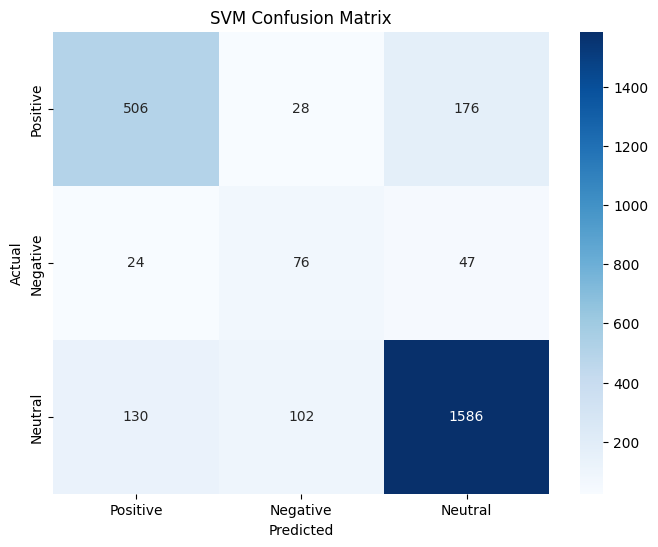


BiLSTM Classification Report:
              precision    recall  f1-score   support

    Positive       0.88      0.81      0.84       710
    Negative       0.50      0.76      0.60       147
     Neutral       0.94      0.93      0.93      1818

    accuracy                           0.89      2675
   macro avg       0.77      0.83      0.79      2675
weighted avg       0.90      0.89      0.89      2675



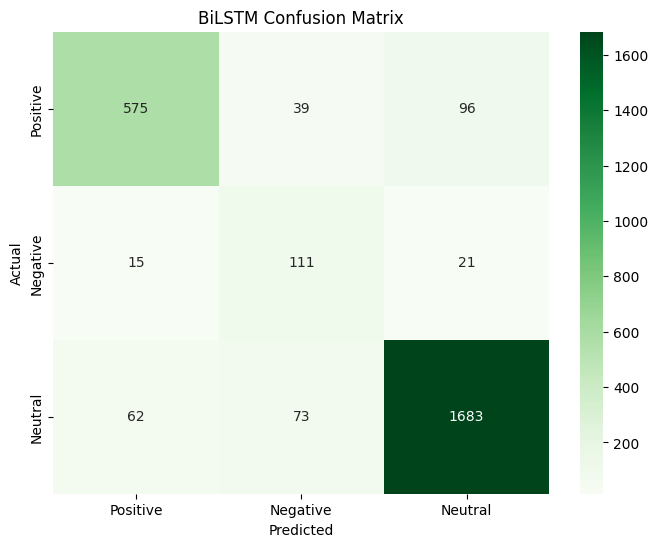

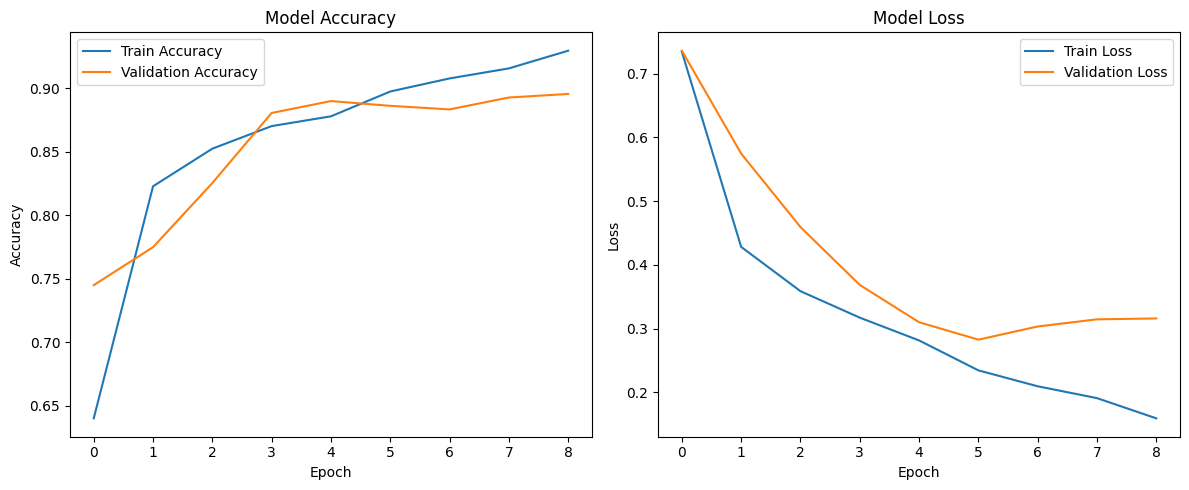


Smart Gating Ensemble Classification Report:
              precision    recall  f1-score   support

    Positive       0.94      0.89      0.91       710
    Negative       0.63      0.81      0.71       147
     Neutral       0.96      0.96      0.96      1818

    accuracy                           0.93      2675
   macro avg       0.84      0.88      0.86      2675
weighted avg       0.94      0.93      0.93      2675



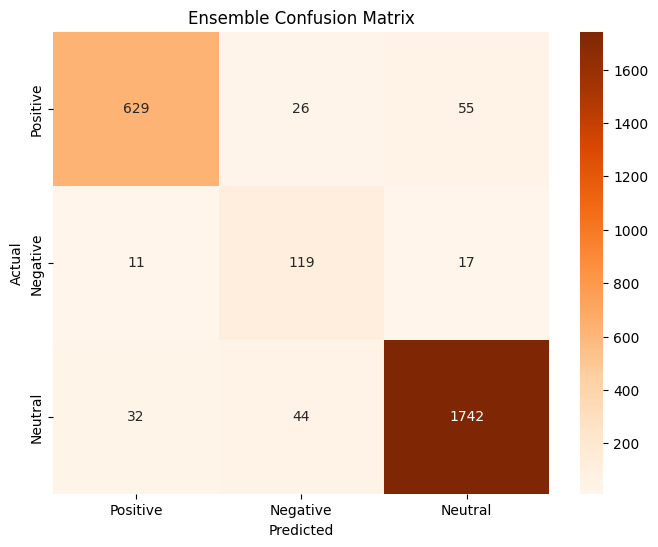

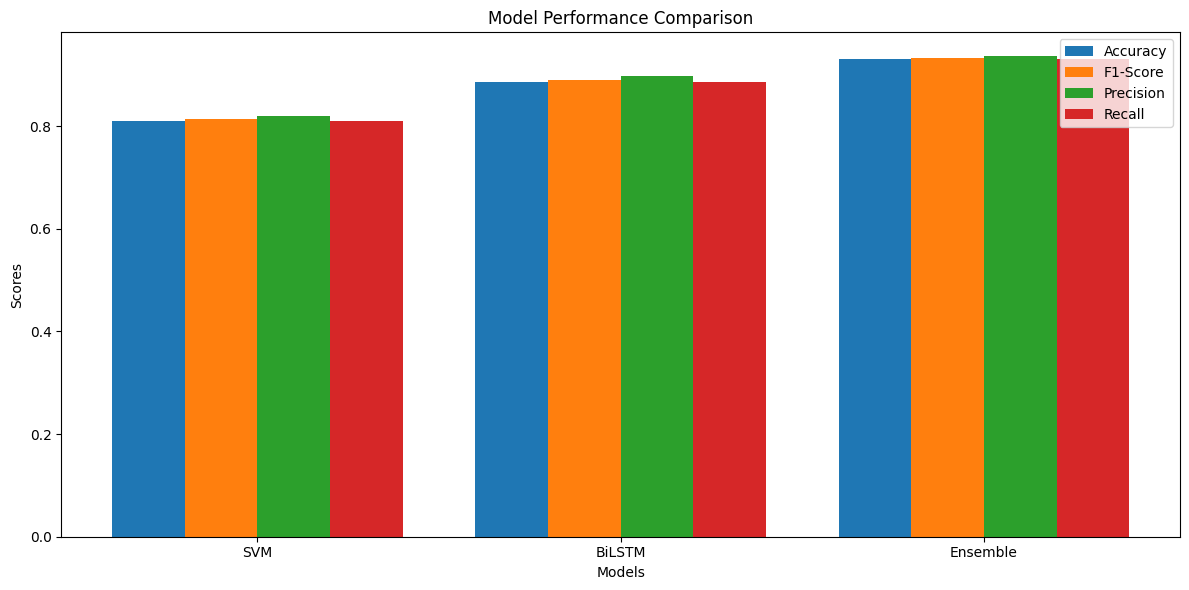

In [20]:
# Add these imports at the top with other imports
!pip install matplotlib seaborn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support

# After SVM evaluation, add visualization
print("\nSVM Classification Report:")
print(classification_report(y_test, svm_pred, target_names=label_map.keys()))

# Plot SVM confusion matrix
plt.figure(figsize=(8,6))
svm_cm = confusion_matrix(y_test, svm_pred)
sns.heatmap(svm_cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_map.keys(), yticklabels=label_map.keys())
plt.title('SVM Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# After BiLSTM evaluation, add visualization
print("\nBiLSTM Classification Report:")
print(classification_report(y_test, bilstm_pred, target_names=label_map.keys()))

# Plot BiLSTM confusion matrix
plt.figure(figsize=(8,6))
bilstm_cm = confusion_matrix(y_test, bilstm_pred)
sns.heatmap(bilstm_cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=label_map.keys(), yticklabels=label_map.keys())
plt.title('BiLSTM Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Plot training history for BiLSTM
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.tight_layout()
plt.show()

# After Smart Gating Ensemble, add comprehensive evaluation
print("\nSmart Gating Ensemble Classification Report:")
print(classification_report(y_test, final_preds, target_names=label_map.keys()))

# Plot ensemble confusion matrix
plt.figure(figsize=(8,6))
ensemble_cm = confusion_matrix(y_test, final_preds)
sns.heatmap(ensemble_cm, annot=True, fmt='d', cmap='Oranges',
            xticklabels=label_map.keys(), yticklabels=label_map.keys())
plt.title('Ensemble Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Model comparison bar chart
models = ['SVM', 'BiLSTM', 'Ensemble']
accuracy = [svm_acc, bilstm_acc, hybrid_acc]
f1_scores = [svm_f1, bilstm_f1, f1_score(y_test, final_preds, average='weighted')]

# Get precision and recall for each model
svm_precision, svm_recall, _, _ = precision_recall_fscore_support(y_test, svm_pred, average='weighted')
bilstm_precision, bilstm_recall, _, _ = precision_recall_fscore_support(y_test, bilstm_pred, average='weighted')
ens_precision, ens_recall, _, _ = precision_recall_fscore_support(y_test, final_preds, average='weighted')

plt.figure(figsize=(12, 6))
x = range(len(models))
width = 0.2

plt.bar(x, accuracy, width, label='Accuracy')
plt.bar([i + width for i in x], f1_scores, width, label='F1-Score')
plt.bar([i + width*2 for i in x], [svm_precision, bilstm_precision, ens_precision], width, label='Precision')
plt.bar([i + width*3 for i in x], [svm_recall, bilstm_recall, ens_recall], width, label='Recall')

plt.xlabel('Models')
plt.ylabel('Scores')
plt.title('Model Performance Comparison')
plt.xticks([i + width*1.5 for i in x], models)
plt.legend()
plt.tight_layout()
plt.show()

# Create models directory and save models

In [21]:

import os
import joblib
import numpy as np
from sklearn.ensemble import RandomForestClassifier

# Create models directory
os.makedirs('models', exist_ok=True)

# --- Save Base Components ---
joblib.dump(tfidf, 'models/tfidf_vectorizer.pkl')
joblib.dump(calibrated_svm, 'models/svm_model.pkl')
joblib.dump(tokenizer, 'models/tokenizer.pkl')
bilstm_model.save('models/bilstm_model.h5')

# --- Smart Gating Classifier Training ---
# (Assuming you've already trained it as per previous discussion)
svm_probs = calibrated_svm.predict_proba(X_test_tfidf)
bilstm_probs = bilstm_model.predict(X_test_padded)
X_meta = np.hstack([svm_probs, bilstm_probs])

svm_preds = calibrated_svm.predict(X_test_tfidf)
bilstm_preds = np.argmax(bilstm_probs, axis=1)
disagreement_mask = svm_preds != bilstm_preds

gate_clf = RandomForestClassifier(n_estimators=100).fit(
    X_meta[disagreement_mask], 
    y_test[disagreement_mask]
)

# --- Save Smart Gating Components ---
joblib.dump(gate_clf, 'models/gating_classifier.pkl')

# --- Save Complete Ensemble Package ---
ensemble_package = {
    'svm_model': calibrated_svm,
    'bilstm_model': bilstm_model,
    'gating_classifier': gate_clf,
    'tfidf_vectorizer': tfidf,
    'tokenizer': tokenizer,
    'max_sequence_length': MAX_SEQUENCE_LENGTH
}
joblib.dump(ensemble_package, 'models/smart_gating_ensemble.pkl')

# --- Update Model Info ---
with open('models/model_info.txt', 'w') as f:
    f.write("best_model_type: smart_gating_ensemble\n")
    f.write(f"best_accuracy: {hybrid_acc:.4f}\n")  # Your 93.64% accuracy
    f.write(f"svm_accuracy: {svm_acc:.4f}\n")
    f.write(f"bilstm_accuracy: {bilstm_acc:.4f}\n")
    f.write(f"max_length: {MAX_SEQUENCE_LENGTH}\n")
    f.write(f"vocab_size: {VOCAB_SIZE}\n")
    f.write(f"embedding_dim: {EMBEDDING_DIM}\n")

print(f"\n🎯 Best Model: SMART_GATING_ENSEMBLE with {hybrid_acc:.4f} accuracy")


84/84 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step

🎯 Best Model: SMART_GATING_ENSEMBLE with 0.9308 accuracy
